## Reconstruction of Complex Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy

### Partitioning

In [2]:
def all_part_maker(N, size_list, color_list):
    return([partitioner(size_list, color_list) for i in range(N)])

def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))
        
def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)
                
    
def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    for part in all_part:  

        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        paran = ((l + 1)/(r+2))

        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]     
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        Z += np.exp(-H_P)
        big_sum += paran* np.exp(-H_P)
        R_ij = big_sum/Z 
    # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))

def H(P):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)


def Metro(T,ens):
    e=[]
    for i in range(ens):
        partitions =  [[i] for i in range(40)].copy()
        for kk in tqdm(range(T)):

            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions)
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n]
            del partitions[m][n]
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a)
            Hf=H(partitions)
            deltaH=Hf-H0
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
            partitions = [ele for ele in partitions if ele != []]
            
        ppp=copy.deepcopy(partitions)
        e.append(ppp)
    return(e)

In [3]:
A_T = np.load('A.npy')
A_O = np.load('Af.npy')
A_T

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [4]:
es = Metro(1000, 10)

100%|██████████| 1000/1000 [00:01<00:00, 520.12it/s]


### Missing Interactions (Removing Links)

#### The Average Reliablity of Absent Links

In [206]:
A_T = np.load('A.npy')

In [207]:
zero_real = []
zero_index = np.where(A_T==0)


for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))
print('the mean value', round(np.mean(zero_real),2))

100%|██████████| 1200/1200 [00:09<00:00, 123.72it/s]

the mean value 0.22


In [208]:
def link_remover(A_T, ratio):
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2))
    return(r)

In [209]:
selected_links = link_remover(A_T, 0.01) 
for link in selected_links: A_T[link[0], link[1]] = 0 
zero_fake=[]
for i in selected_links:
    zero_fake.append(R(i[0], i[1], A_T, es))
print('the mean value', round(np.mean(zero_fake),2))

the mean value 0.5


In [210]:
all_real = []
for i in zero_fake: all_real.append([1, i])
for i in zero_real: all_real.append([0, i])

In [211]:
#sorting 

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()
Sort(all_real)
all_real[:10]

[[0, 0.75],
 [0, 0.75],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451],
 [0, 0.7451]]

In [212]:
#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0]) 
# Driver code
ext=Extract(all_real)

In [213]:
def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones
    

In [214]:
acc(ext)

0.8825000000000001

In [227]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('A.npy')
    selected_links = link_remover(A_T, r) 
    for link in selected_links: A_T[link[0], link[1]] = 0 
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 0.45
the mean value 0.4
the mean value 0.39
the mean value 0.39
the mean value 0.36
the mean value 0.34
the mean value 0.31
the mean value 0.27
the mean value 0.29
the mean value 0.21


Text(0.5, 1.0, 'Missing intractions')

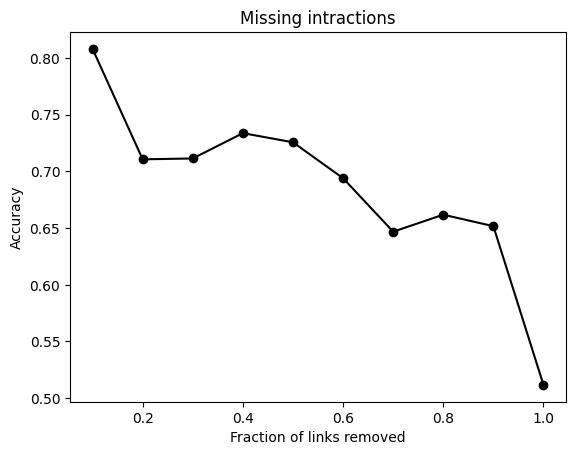

In [233]:
plt.plot(rat,accs,'-o',color='black')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')